In [1]:
#!pip install biopython
import sys, os, copy, pprint, glob
import datetime, json
#import pathlib
import matplotlib.pyplot as plt

from importlib import reload
import pathlib, importlib
import csv, fnmatch, random
import Bio.Entrez #used by accessions_to_gb
from ftplib import FTP
from io import StringIO
import pandas as pd
import numpy as np

from Bio import SeqIO
import BLAST.BlastRun as BlastRun
import BLAST.seq_interval as seq_interval
import utils.IO as IO
import utils.MolBio as MB
from Bio import Align
from PIL import Image

IO.py


In [196]:
#Set Work directory:
ud="/tdata1/betacoronavirus/"
seq_ud=ud+'seqs/'
genomic_fn='coronarefseq_NC_045512.fa'
gene_fn='coronarefseq_NC_045512.txt'
genbank_fn='NC_045512_.gb'
gisaid_fn='gisaid_cov2020_sequences_20200416.fasta'

In [197]:
tc=IO.TimeCode()
print(tc)

20200416T1511


In [169]:
class Genbank_Record:
    def __init__(self, record):
        self.gb=record
        self.gene_dict =dict((feat.qualifiers['gene'][0], feat) for feat in list(filter(lambda x:x.type=='CDS', self.gb.features)))
        self.Acc=self.gb.id
        self.seq=self.gb.seq
    def seq(self, gene_name=''):
        if not(gene_name):
            return self.seq.encode().decode()
        else:
            s=(self.gene_dict[gene_name].extract(self.seq))
            return s.encode().decode()
    def to_fasta(self, feature):
        gene_name=feature.qualifiers['gene'][0]
        s=feature.extract(self.seq)
        seq=s.encode().decode()
        #feature.location.start.position, feature.location.end.position,
        fa_label='%s|%s|%s|'%(self.gb.id, gene_name, str(feature.location))
        return [fa_label, seq]
    def iter_features(self):
        lst=list(self.gene_dict.values())
        lst.sort(key=lambda x:x.location.start.position)
        for feat in lst:
            yield feat
        
def load_genbank(gb_path):
    lst=[]
    with open(gb_path, "r") as input_handle:
        for record in SeqIO.parse(input_handle, "genbank"):
            lst.append(Genbank_Record(record))
    return lst

In [170]:
l=load_genbank(seq_ud+genbank_fn)
r=l[0]
for f in r.iter_features():
    print(f.location.start.position, str(r.to_fasta(f))[:100])

265 ['NC_045512.2|ORF1ab|[265:13483](+)|', 'ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTT
21562 ['NC_045512.2|S|[21562:25384](+)|', 'ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGA
25392 ['NC_045512.2|ORF3a|[25392:26220](+)|', 'ATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAAT
26244 ['NC_045512.2|E|[26244:26472](+)|', 'ATGTACTCATTCGTTTCGGAAGAGACAGGTACGTTAATAGTTAATAGCGTACTTCTTTTTCTT
26522 ['NC_045512.2|M|[26522:27191](+)|', 'ATGGCAGATTCCAACGGTACTATTACCGTTGAAGAGCTTAAAAAGCTCCTTGAACAATGGAAC
27201 ['NC_045512.2|ORF6|[27201:27387](+)|', 'ATGTTTCATCTCGTTGACTTTCAGGTTACTATAGCAGAGATATTACTAATTATTATGAGG
27393 ['NC_045512.2|ORF7a|[27393:27759](+)|', 'ATGAAAATTATTCTTTTCTTGGCACTGATAACACTCGCTACTTGTGAGCTTTATCACTA
27755 ['NC_045512.2|ORF7b|[27755:27887](+)|', 'ATGATTGAACTTTCATTAATTGACTTCTATTTGTGCTTTTTAGCCTTTCTGCTATTCCT
27893 ['NC_045512.2|ORF8|[27893:28259](+)|', 'ATGAAATTTCTTGTTTTCTTAGGAATCATCACAACTGTAGCTGCATTTCACCAAGAATGT
28273 ['NC_045512.2|N|[28273:29533](+)|

In [67]:
f.location.start.position

29557

## Cleanup Sequences for BLAST

In [198]:
#Cleanup
gisaid_fn='gisaid_cov2020_sequences_20200416.fasta'
ofp=open(seq_ud+'f'+gisaid_fn, 'w')
idx=0
for q_rec in SeqIO.parse(seq_ud+gisaid_fn, "fasta"):
    print(idx, q_rec.id, end='\r')
    label=q_rec.name.replace('\n', '').strip()
    seq=q_rec.seq.__str__().replace('-','').replace(' ','')
    ofp.write('>%s\n%s\n'%(label, seq))
    idx+=1
    
# subj_pth=seq_ud+'s.fa'
# query_pth=seq_ud+'q.fa'

# SeqIO.write(r.gb, subj_pth, "fasta")
# SeqIO.write(q_rec, query_pth, "fasta")


## Run Blast

In [199]:
def runBlast(query_path, seq_ud, bo_path='', subj_pth='', fdb_path=''):
    if not(bo_path):
        bo_path=seq_ud+'bo_generic.json'
    subj_FDB = BlastRun.FormatDB(subj_pth, fdb_path, input_type='fasta', dbtype = 'nucl', title = "")
    if not(subj_FDB.AlreadyExists()):
        subj_FDB.RunFromFDB(parse_seqids=False)
    
    blast_params={
                      'dust':"no",
                      'outfmt':15,
                      'num_threads':15,
                      'word_size':7,
                      'max_target_seqs': 100000
                      }
    BR=BlastRun.BlastRunObj(query_path, bo_path, fdb_path, blast_params=blast_params)
    BR.make_cmd()
    print(BR.cmd)
    return BR.RunBlast()

query_path=seq_ud+gisaid_fn
fdb_path=seq_ud+'refseq_covid19'

runBlast(query_path, seq_ud,  bo_path='', subj_pth='', fdb_path=fdb_path)

cmdstr: blastdbcmd -db /tdata1/betacoronavirus/seqs/refseq_covid19 -entry all -outfmt "%t %l"|tee /tdata1/betacoronavirus/seqs/SLST.TXT
ListBlastDB: returning 1 recs
cmdstr: blastdbcmd -db /tdata1/betacoronavirus/seqs/refseq_covid19 -entry all -outfmt "%t %l"|tee /tdata1/betacoronavirus/seqs/SLST.TXT
ListBlastDB: returning 1 recs
FormatDB::AlreadyExists: /tdata1/betacoronavirus/seqs/refseq_covid19.nsq  exists: True
blastn  -query /tdata1/betacoronavirus/seqs/gisaid_cov2020_sequences_20200416.fasta -out /tdata1/betacoronavirus/seqs/bo_generic.json -db /tdata1/betacoronavirus/seqs/refseq_covid19 -dust no -outfmt 15 -num_threads 15 -word_size 7 -max_target_seqs 100000;


'/tdata1/betacoronavirus/seqs/bo_generic.json'

In [200]:
class HSP(seqInterval):
    def __init__(self, hsp):
        self.qseq= hsp['qseq']
        self.hseq= hsp['hseq']
        self.matchline= hsp['midline']
        self.n=len(self.matchline)
        self.score=hsp['score']
        self.align_len=hsp['align_len']
        self.similarity_score=hsp['identity']/float(hsp['align_len'])
        self.query_start=int(hsp['query_from'])
        self.query_to=int(hsp['query_to'])
        self.query_strand=hsp['query_strand']
        self.subj_start=int(hsp['hit_from'])
        self.subj_to=int(hsp['hit_to'])
        self.subj_strand=hsp['hit_strand']
        self.same_strand=self.query_strand==self.subj_strand
        seqInterval.__init__(self, self.subj_start,self.subj_to,'subj_blast', key_block_size=100000)
        self.mismatch_dict=self.make_mm_dict(hsp)
    def make_mm_dict(self, hsp):
        d={}
        if (not(self.same_strand) or self.subj_start>self.subj_to):
            self.antisense()
            #raise Exception('spam', 'eggs')
        pos=self.subj_start
        for i in range(self.n):
            #ToDo This is a Hack and needs to be fixed for Inserts
            pos+=1
            if self.hseq[i]=='-':
                d[pos]='I%s'%self.qseq[i]
                continue
            elif self.matchline[i]==' ':
                d[pos]='%s>%s'%(self.hseq[i], self.qseq[i])
        return d
    def antisense(self):
        #print('Antisense')
        self.matchline=MB.StrReverse(self.matchline)
        self.query_strand=MB.Antisense(self.query_strand)
        self.subj_strand=MB.Antisense(self.subj_strand)
        s=self.subj_start
        self.subj_start=self.subj_to
        self.subj_to=s
        s=self.query_start
        self.query_start=self.query_to
        self.query_to=s
    def display(self, delta=25):
        for i in range(0, self.n, delta):
            if not(' ' in self.matchline[i:i+delta]):continue#skips uninformative alignments
            print(self.hseq[i:i+delta], self.subj_start+i+delta)
            print(self.matchline[i:i+delta])
            print(self.qseq[i:i+delta], self.query_start+i+delta)
            print()

class Hit:
    def __init__(self, hit):
        self.query_name=hit['description'][0]['title']
        self.subj_label=hit['description'][0]['title']
        self.subj_acc=hit['description'][0]['accession']
        self.query_len=hit['query_len']
        self.num_hsp=len(hit['hsps'])
        self.hit_id=hit['num']
        self.match_dict={}
        self.hspLst=[]
        self.align_len=0
        #assumes hsp order is from best to worst
        for hsp in hit['hsps'][:1]:##ToDo: FIX!! This is a HACK!!!
            H=HSP(hsp);use_hsp=True
            for phsp in self.hspLst:
                if phsp.intersect(H):
                    use_hsp=False
            if use_hsp:
                self.hspLst.append(H)
        print('num_hsps', len(hit['hsps']), 'accepted:', len(self.hspLst))
        similarity=0.0
        for hsp in self.hspLst:
            self.match_dict.update(hsp.mismatch_dict)
            self.align_len+=hsp.align_len
            similarity+=(hsp.similarity_score*hsp.align_len)
        self.hsp_similarity=similarity/self.align_len
        self.query_similarity=self.align_len/self.query_len*self.hsp_similarity
    def display(self):
        print(self.query_name, self.num_hsp, self.align_len, self.query_len, self.hsp_similarity, self.query_similarity)
        
        

def OLDrun_parse_blast(seq_ud, bo_path):
    bo_json=json.loads(open(bo_path).read())
    d={}
    for bb in bo_json["BlastOutput2"]:
        report=bb["report"]
        query_label=report['results']["search"]["query_title"]
        for hit in report['results']["search"]["hits"]:
            h=Hit(hit)
            d=h.mm_dict()
            if None:
                h.display()
                for k, v in d.items():
                    p=k-h.subj_start
                    print(k, v, h.hseq[p], h.hseq[p-1:p+2])
            break
    return d

def run_parse_blast(bo_json):
    d={}
    report=bo_json["report"]
    query_label=report['results']["search"]["query_title"]
    query_len=report['results']["search"]["query_len"]
    for hit in report['results']["search"]["hits"]:
        hit['query_len']=query_len
        hit_obj=Hit(hit)
        if hit_obj.align_len>300:
            d.update(hit_obj.match_dict)
    return query_label, d
    

In [ ]:
def find_start_end(bo_path, read_size=1000000):
    """Used to test json blast outputs output option 15"""
    find_startpoint = lambda b, p: b.find("\n{\n", p+1)
    find_endpoint = lambda b, p: b.find("\n  }\n", p+1)
    fp=open(bo_path, 'r')
    file_sz=os.path.getsize(bo_path)
    #find"\n{\n" and tail with " }\n"}
    b=' ';pos=0;slst=[];elst=[]
    buffer_start_pos=fp.tell()
    find_start=True
    while buffer_start_pos < file_sz:
        buffer_start_pos=fp.tell()
        print('fp:', buffer_start_pos, 'find_start', find_start)
        b=fp.read(read_size)
        p=1
        while p>0:
            p=find_startpoint(b,p)
            if p>0:
                slst.append(p)
        p=1
        while p>0:
            p=find_endpoint(b,p)
            if p>0:
                elst.append(p)
    return slst, elst
        
def iter_blast_out_json(bo_path, read_size=1000000):
    """Used to iterate over large json blast outputs output option 15"""
    find_startpoint = lambda b, p: b.find("\n{\n", p+1)
    find_endpoint = lambda b, p: b.find("\n  }\n", p+1)
    
    fp=open(bo_path, 'r')
    file_sz=os.path.getsize(bo_path)
    #find"\n{\n" and tail with " }\n"}
    b=' ';pos=0;lst=[]
    start_point=end_point=-1
    buffer_start_pos=fp.tell()
    find_start=True
    idx=0
    while buffer_start_pos < file_sz:
        buffer_start_pos=fp.tell()
        #print('fp:', buffer_start_pos, 'find_start', find_start)
        b=fp.read(read_size)
        current_fpos=fp.tell()
        p=1
        while p>0:
            if find_start:
                p=find_startpoint(b, p)
                if p>0:
                    start_point=buffer_start_pos+p
                    #print('found start', start_point)
                    find_start=False
            else:
                p=find_endpoint(b, p)
                if p>0:
                    end_point=buffer_start_pos+p
                    #print('found end', end_point)
                    print('\n', idx, 'found start, end', start_point, end_point, end_point-start_point)
                    idx+=1
                    lst.append([start_point, end_point+4])
                    s,e=lst[-1]
                    fp.seek(s)
                    yield json.loads(fp.read(e-s))
                    
                    fp.seek(current_fpos)
                    find_start=True
    if None:
        print(lst)
        for p in lst:
            s,e=p
            fp.seek(s)
            print(s, 'start_>%s<'%fp.read(20))
            fp.seek(e)
            print(e, 'end_>%s<'%fp.read(20))
    fp.close()

bo_path=ud+'seqs/bo_gsaid_8k.json'#bo_primer_corona.txt'#
print(os.path.getsize(bo_path))
jLst=[]
mut_dict={};idx=0
for x in iter_blast_out_json(bo_path):
    query_label, d=run_parse_blast(x)
    k='%i_%s'%(idx, query_label)
    print(k, len(d))
    mut_dict[k]=d
    idx+=1
    jLst.append(x)
    if None:
        s=str(x)
        print(s[:20], '\n', s[-20:])
    
#find_start_end(bo_path, read_size=1000000)

In [202]:
mut_dict['8000_hCoV-19/England/SHEF-C08B9/2020|EPI_ISL_420171|2020-03-24']

{242: 'C>T',
 3038: 'C>T',
 14409: 'C>T',
 18714: 'C>T',
 23404: 'A>G',
 28882: 'G>A',
 28883: 'G>A',
 28884: 'G>C'}

In [154]:
def DateSort(mut_dict):
    mlst=[];max_x=0
    for r in mut_dict.keys():
        #print(r, len(mut_dict[r]), end='\r')
        try:
            yr, m, d = r.split('|')[2].split('-')
        except:
            print('FAIL', r)
            continue
        dtime=datetime.datetime(int(yr),int(m),int(d))
        mlst.append([dtime, r, mut_dict[r]])
        for k in mut_dict[r].keys():
            if k >max_x:
                max_x=k
    mlst.sort(key=lambda x:x[0])
    l=[[0.0 for i in range(30000)] for x in range(len(mlst))]

    for i in range(len(mlst)):
        for k in mlst[i][2].keys():
            l[i][k]=1.0
    arr=np.array(l)
    img = Image.fromarray(np.uint8(arr*254))
    img.save(ud+'pil_red.png')
    print(max_x)
    return img

def get_base(s):
    if 'I' in s:
        return 'I'
    return s.split('>')[1].upper()
    
def get_color(s):
    b=get_base(s)
    color_dict={
        '-':[250, 60, 200, 254],
        'G':[254,0,254, 254],
        'A':[0,254,0, 254],
        'T':[0,0,254, 254],
        'C':[120, 120, 0, 254],
    }
    if b in color_dict:
        return color_dict[b]
    else:
        return [254,0,0, 254]
    
def NumMutSort(mut_dict, ud):
    mlst=[];max_x=0
    for r in mut_dict.keys():
        #print(r, len(mut_dict[r]), end='\r')
        mlst.append([r, mut_dict[r]])
        for k in mut_dict[r].keys():
            if k >max_x:
                max_x=k
    mlst.sort(key=lambda x:len(x[1]))
    l=[[[0,0,0, 120] for i in range(30000)] for x in range(len(mlst))]
    for i in range(len(mlst)):
        for k in mlst[i][1].keys():
            l[i][k]=get_color(mlst[i][1][k])
    arr=np.array(l)
    img = Image.fromarray(np.uint8(arr))
    img.save(ud+'pil_red_nummutsort.png')
    print(max_x)
    return img

In [155]:
#Draw Alignment Picture
print(len(mut_dict))
img=NumMutSort(mut_dict, ud)
img.save(ud+'pil_red_nummutsort.png')

8086
29899


In [203]:
#Compute Entropy
import math
def entropy(l):
    s=0;sumv=sum(l)
    for v in l:
        p=v/sumv
        s+=-1*p*math.log(p, 2.0)
    return s

genome_sz=30000;N=len(mut_dict)
posdict=[{} for i in range(genome_sz)]
posLst=[0 for i in range(genome_sz)]
for label in mut_dict:
    for k in mut_dict[label].keys():
        posLst[k]+=1
        base=get_base(mut_dict[label][k])
        if not(base in posdict[k]):posdict[k][base]=0
        posdict[k][base]+=1

entropyLst=[]
for i in range(genome_sz):
    l=list(posdict[i].values())
    v=N-sum(l)
    l.append(v)
    entropyLst.append(entropy(l))
    

In [204]:
#Make Gene Intervals
gene_idx=1;gene_plotLst=[]
for f in r.iter_features():
    fa_obj=r.to_fasta(f)
    s,e=f.location.start.position, f.location.end.position
    gene=fa_obj[0].split('|')[1]
    gene_name = '%s [%i, %i]'%(gene, s,e)
    gene_plotLst.append([gene_name, 1+10*gene_idx, s,e])
    print(f.location.start.position, str(fa_obj[0])[:100])
    gene_idx+=1

265 NC_045512.2|ORF1ab|[265:13483](+)|
21562 NC_045512.2|S|[21562:25384](+)|
25392 NC_045512.2|ORF3a|[25392:26220](+)|
26244 NC_045512.2|E|[26244:26472](+)|
26522 NC_045512.2|M|[26522:27191](+)|
27201 NC_045512.2|ORF6|[27201:27387](+)|
27393 NC_045512.2|ORF7a|[27393:27759](+)|
27755 NC_045512.2|ORF7b|[27755:27887](+)|
27893 NC_045512.2|ORF8|[27893:28259](+)|
28273 NC_045512.2|N|[28273:29533](+)|
29557 NC_045512.2|ORF10|[29557:29674](+)|


In [205]:
pcr_df=pd.read_csv(seq_ud+'refseq_pcr_20200416T1422.csv')
rtpcrLst=[]
for idx, rec in pcr_df.iterrows():
    if 0<rec.refseq_hit_region_size<1000:
        s,e=rec.rtpcr_refseq_start, rec.rtpcr_refseq_end
        pcr_label='%s [%i, %i]'%(rec.F, s,e)
        rtpcrLst.append([pcr_label, idx*100, s,e])
rtpcrLst

[['G1|F|CDC|2019-nCoV_N1-F [28287, 28358]', 0, 28287.0, 28358.0],
 ['G2|F|CDC|2019-nCoV_N2-F [29164, 29230]', 100, 29164.0, 29230.0],
 ['G3|F|CDC|2019-nCoV_N3-F [28681, 28752]', 200, 28681.0, 28752.0],
 ['G5|F|CDC-2|Cor-p-F2 [15285, 15680]', 400, 15285.0, 15680.0],
 ['G6|F|CDC-2|Cor-p-F3 [15340, 15736]', 500, 15340.0, 15736.0],
 ['G7|F|China|ORF1ab_F [13342, 13460]', 600, 13342.0, 13460.0],
 ['G8|F|China|N_F [28881, 28979]', 700, 28881.0, 28979.0],
 ['G11|F|HongKong|HKU-ORF1b-nsp14F [18778, 18909]', 1000, 18778.0, 18909.0],
 ['G12|F|HongKong|HKU-NF [29145, 29254]', 1100, 29145.0, 29254.0],
 ['G13|F|Thailand|WH-NIC_N-F [28320, 28376]', 1200, 28320.0, 28376.0],
 ['G14|F|Japan|NIID_WH-1_F509_F [484, 896]', 1300, 484.0, 896.0],
 ['G15|F|Japan|NIID_WH-1_Seq_F519_F [502, 837]', 1400, 502.0, 837.0],
 ['G16|F|Japan|WuhanCoV-spk1-f_F [24354, 24900]', 1500, 24354.0, 24900.0],
 ['G17|F|Japan|NIID_WH-1_F24381_F [24364, 24856]', 1600, 24364.0, 24856.0],
 ['G18|F|Japan|NIID_WH-1_Seq_F24383_F [24366,

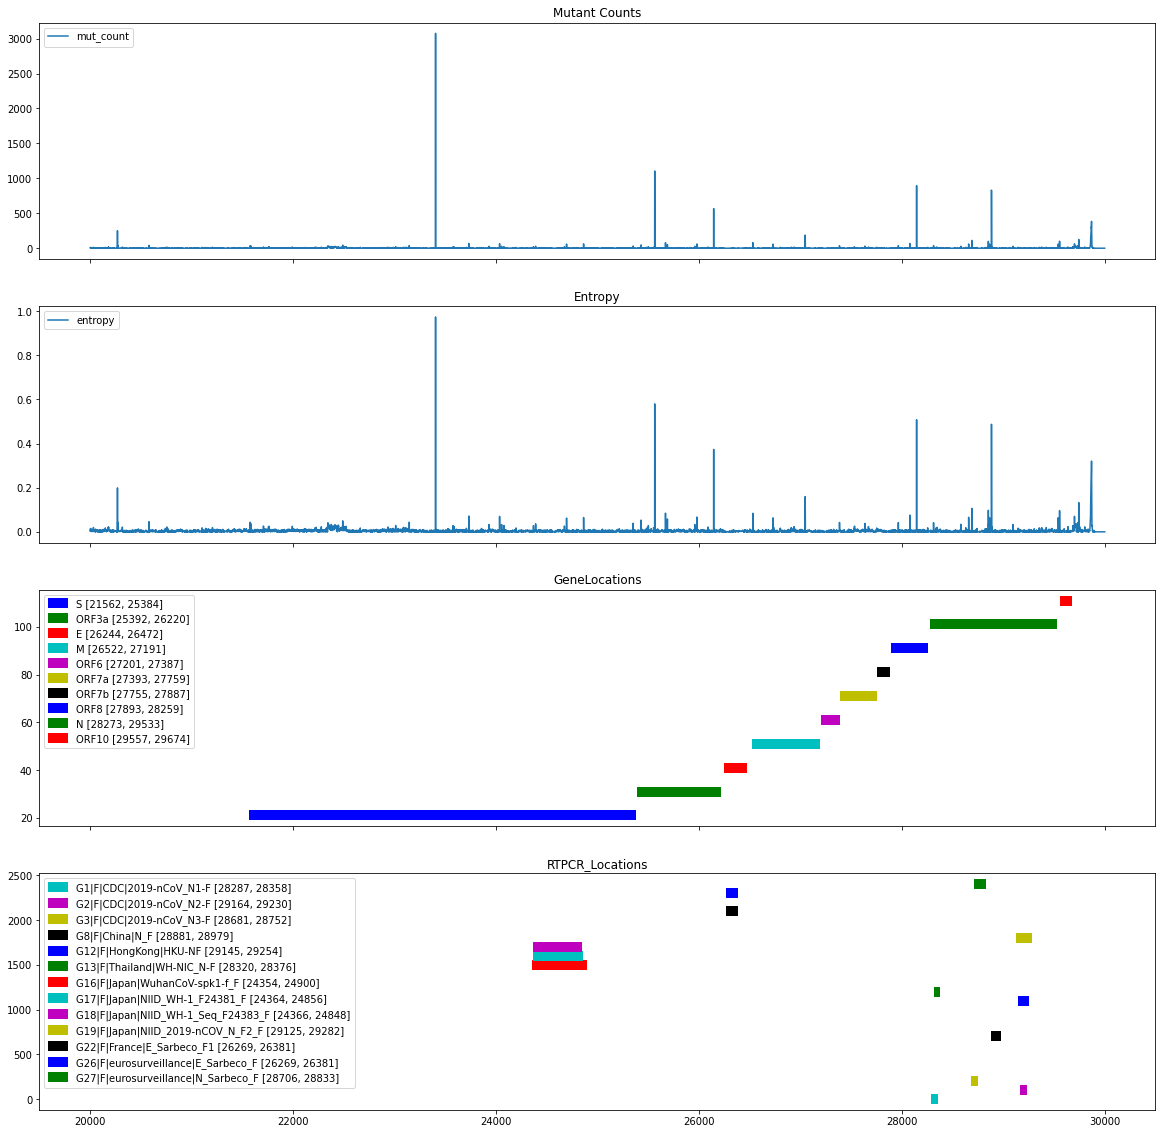

In [206]:
from matplotlib import pyplot as plt

start_idx, end_idx=(20000,30000)#(0,genome_sz)
colorsLst=['b', 'g', 'r', 'c', 'm', 'y', 'k']
LL=['idx', 'mut_count', 'entropy']
plotLst=np.array([range(start_idx, end_idx, 1), posLst[start_idx:end_idx], entropyLst[start_idx:end_idx]])
df=pd.DataFrame(plotLst.T, columns=LL)

MVwindow=50
rolling_mean = df.entropy.rolling(window=MVwindow).mean()*10
#rolling_mean2 = df.mut_count.rolling(window=10).mean()
#https://towardsdatascience.com/implementing-moving-averages-in-python-1ad28e636f9d

fig, axs = plt.subplots(4, figsize=(20,20), sharex=True)

axs[0].set_title('Mutant Counts')
axs[0].plot(df.idx, df.mut_count, label='mut_count')
axs[0].legend(loc='upper left')
#plt.plot(df.idx, rolling_mean2, label='mut_count 10', color='magenta')
axs[1].plot(df.idx, df.entropy, label='entropy')
#axs[1].plot(df.idx, rolling_mean, label='entropy MV%i'%MVwindow, color='orange')
axs[1].set_title('Entropy')
axs[1].legend(loc='upper left')

i=0
for gene, y, xmin, xmax in gene_plotLst:
    if not((start_idx<xmin<end_idx) or (start_idx<xmax<end_idx)):continue
    xmin=max(start_idx, xmin)
    xmax=min(end_idx, xmax)
    axs[2].hlines(y, xmin, xmax, colors=colorsLst[i%len(colorsLst)], linestyles='solid', label=gene, linewidth=10)
    i+=1
axs[2].set_title('GeneLocations')
axs[2].legend(loc='upper left')

for primer_set, y, xmin, xmax in rtpcrLst:
    if not((start_idx<xmin<end_idx) or (start_idx<xmax<end_idx)):continue
    xmin=max(start_idx, xmin)
    xmax=min(end_idx, xmax)
    axs[3].hlines(y, xmin, xmax, colors=colorsLst[i%len(colorsLst)], linestyles='solid', label=primer_set, linewidth=10)
    i+=1
axs[3].set_title('RTPCR_Locations')
axs[3].legend(loc='upper left')

plt.show()

#plt.plot(posLst)

In [209]:
#Extract Design Region
genomic_fn='coronarefseq_NC_045512.fa'
ofp=open(seq_ud+'covid_lamp_design_region.fa', 'w')
idx=0
for q_rec in SeqIO.parse(seq_ud+genomic_fn, "fasta"):
    print(idx, q_rec.id, end='\r')
    idx+=1

s,e=24000, 24500
label=q_rec.name.replace('\n', '').strip()+'|%i:%i'%(s,e)
seq=q_rec.seq.__str__().replace('-','').replace(' ','')[s:e]
ofp.write('>%s\n%s\n'%(label, seq))
ofp.close()

## Lamp Designer:
http://loopamp.eiken.co.jp/e/lamp/primer.html  

https://primerexplorer.jp/e/

In [160]:
entropy([1000,7000]), entropy([3000, 5000]), entropy([4000, 4000]), entropy([2000, 2000, 2000, 2000]), entropy([200, 200, 200, 7400])

(0.5435644431995964, 0.9544340029249649, 1.0, 2.0, 0.5031837316805837)

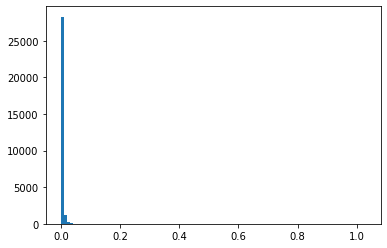

In [173]:
pp=plt.hist(df.entropy, bins=100)

## Compute Similarity for collected CoV

In [ ]:
colected_corona_path=seq_ud+'collected_corona_viruses.fa'
bo_path=seq_ud+'bo_collected_corona.txt'
#runBlast(colected_corona_path, seq_ud,  bo_path=bo_path, subj_pth, fdb_path=fdb_path)
oLst=[]
hitLst=[]
for bo_json in iter_blast_out_json(bo_path):
    report=bo_json["report"]
    query_label=report['results']["search"]["query_title"]
    query_len=report['results']["search"]["query_len"]
    query_similarity=-1
    if report['results']["search"]["hits"]:
        hit = report['results']["search"]["hits"][0]
        hit['query_len']=query_len
        hit_obj=Hit(hit)
        query_similarity=hit_obj.query_similarity
        hitLst.append(hit_obj)
    oLst.append([query_label, len(hit_obj.hspLst), query_len, query_similarity])

df=pd.DataFrame(oLst, columns=['query_label', 'num_hsp', 'query_len', 'query_similarity'])
df.to_csv(ud+'collected_corv.csv')

In [ ]:
hitLst[27].display()

In [ ]:
fpth=ud+'errorlogs.txt'
b=open(fpth, 'r').read()
l=b.split('COUNT: ')
l=[x[2:] for x in l]
df=pd.DataFrame(l, columns=['x'])
df.to_csv(ud+'errorlogs.csv')

## Deprecation Line

In [ ]:
#seq by seq blast and parse

mut_dict={};i=0
for q_rec in SeqIO.parse(seq_ud+gisaid_fn, "fasta"):
    print(i, len(mut_dict), q_rec.id, end='\r')
    SeqIO.write(q_rec, query_pth, "fasta")
    d=run_parse_blast(seq_ud, fdb_path, query_pth)
    mut_dict.update(d)
    i+=1
mut_dict